# Empirical Bernstein Stopping (EBS) Algorithm

The empirical Bernstein stopping (EBS) algorithm is a stopping algorithm which adaptively determines when to stop a sampling process.
EBS is build on the empirical Bernstein inequality [[1](https://www.cs.toronto.edu/~vmnih/docs/ebstop.pdf)], which is a modification of the Bernstein inequality.

The EBS algorithm employs the following information:
- the range $R$ of the random variables --> $\forall X_i: a_i \leq X_i \leq b_i$ hence $R = b - a$,
- the empirical variance $\overline{\sigma^2}_t=\frac{1}{t}\sum^t_{i=1}(X_i-\overline{X}_t)^2$, with $t$ being the amount of samples taken,

of the random variable $X$.

This algorithm returns an $(\epsilon,\delta)$-estimate which is at most $\epsilon$ from its actual mean with prob. at least $1-\delta$.\
Furthermore, it the following parameters characterize EBS:
- the accuracy $\epsilon$, which can be absolute or relative,
- the confidence $1-\delta$, which is the probability to return an $\epsilon$-close estimate.

In addition to various modifications to EBS, algorithms which are based on the Höffding's inequality are also included.\
This notebook may serve as a demonstration on how to use the provided algorithms.

## Important Functions

- `cond_check()`: Checks stopping condition
- `add_sample(sample)`: Processes a fresh sample
- `get_estimate()`: Returns the (current) estimate
- `get_mean()`: Returns an numpy array with the tracked running means
- `get_var()`: Returns an numpy array with the tracked running variances
- `get_step()`: Returns the amount of samples taken
- `get_ct()`: Returns the current bound on which the stopping condition is based on

While there are more functions in the respective classes, these are the only ones that should be used.

## Usage

In [1]:
import sys
import numpy as np

# Importing the algorithms
sys.path.append("./")
import src.algorithms as alg

Define some variables for the random variable/ distribution and EBS.\
In this example, a uniform distribution is used.

In [2]:
a = 0
b = 1
R = b - a
actual_mean = R/2 
delta = 0.1
epsilon = 0.01

Create an instance of the `eba_geo_marg` ebs class.

In [8]:
ebs = alg.eba_geo_marg(epsilon=epsilon,delta=delta,range_of_rndvar= R)

In [9]:
np.random.seed(425)

The loop where the algorithm is actually running.

In [10]:
while ebs.cond_check():
    for _ in range(ebs.next_batch_size):
        ebs.add_sample(np.random.uniform(a,b))
    ebs.update_ct()

The function `ebs.cond_check()` checks if the stopping condition of the respective algorithm is met.
While that function returns true, more samples are processed via `ebs.add_sample()`.
For the algorithms that utilise geometric sampling the function `ebs.inner_cond_check()` has to be additionaly called as-well.
That means for the `eba_geo_marg` and `eba_geo` algorithms.

When terminated, various one can return various information from EBS.

In [11]:
print('Estimate: ',ebs.get_estimate())
print('# Samples:',ebs.get_step())

Estimate:  0.4988872008927465
# Samples: 27298


## Visualising

In [12]:
import matplotlib.pyplot as plt

In [13]:
x_values = np.arange(0,ebs.get_step())
y_values = ebs.get_mean()

Amount of samples given by Höffding's bound, $t_\text{min}$

In [14]:
tmin = alg.hoeffding_bound(delta,epsilon,R)

Below the running mean is plotted.
Additionally, a $\pm \epsilon$ regime around the actual mean $\mu = 0.5$ is displayed.

The amount of samples EBS required are shown as a red line, while Höffding's bound is blue line.

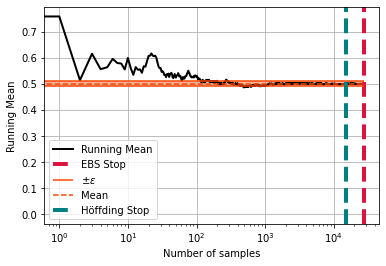

In [15]:
plt.grid()
plt.xlabel('Number of samples')
plt.ylabel('Running Mean')
plt.semilogx(x_values,y_values,label = 'Running Mean',c = 'black',lw = 2)
plt.axvline(ebs.get_step(),linestyle = '--',c = 'crimson',lw = 4,label = r"EBS Stop")
plt.hlines([actual_mean-epsilon, actual_mean+epsilon], xmin=0, xmax=ebs.get_step(),color = 'orangered',label=r'$\pm \epsilon$')
plt.hlines(actual_mean,xmin=0,xmax=ebs.get_step(),label = 'Mean',alpha = 0.99,linestyle = '--',color = 'orangered')
plt.fill_between([0, ebs.get_step()], y2 = actual_mean-epsilon,y1=actual_mean+epsilon, facecolor='orangered',alpha = 0.4)
plt.axvline(tmin,linestyle = '--',c = 'teal',lw = 4,label = r"Höffding Stop")
plt.legend()

## Using EBS in a Practical Applications: Electronic Structure Problem for $\text{H}_2$

Using the ansatz provided in this [paper](pdf/ScalableQuantumSimulationofMolecularEnergies.pdf), i.e.:

![title](pdf/h2_circuit.png)

The corresponding Hamiltonian is:
$$
\hat{\text{H}}=g_1 1_{2\times 2}+g_2 Z_0 + g_3  Z_1 + g_4 (Z_0 \otimes Z_1) + g_5 (Y_0 \otimes Y_1) + g_6 (X_0 \otimes X_1)
$$
with $\{g_i\}$ being parameters whose value depends solely on the bond length $d$ (see [thesis](pdf/Bachelor_Thesis.pdf)).

For example for $d = 0.75 \mathring{A}$, which is near the dissociation energy of $\text{H}_2$, a VQE run using EBS for all Energy estimations looks as follows:

In [15]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./")
from dep.qm_vqe import *

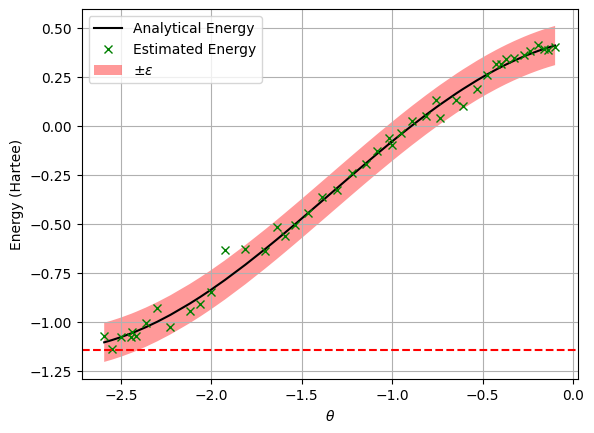

In [16]:
epsilon = 0.1
arr_par1, arr_energy,arr_var, arr_est_energy, arr_est_var, arr_steps, arr_höf,arr_max_flag = vqe_eps(epsilon)
arr_energy = np.array(arr_energy)
# Default g --> d = 0.75
g = [0.2252, 0.3435, -0.4347,0.5716,0.0910, 0.0910]

plt.plot(arr_par1, arr_energy,'k-' ,label='Analytical Energy')
plt.plot(arr_par1, arr_est_energy,'gx' ,label='Estimated Energy')
plt.fill_between(arr_par1, arr_energy-epsilon, arr_energy+epsilon,facecolor = 'red',alpha = 0.4,label = r'$\pm \epsilon$')
plt.axhline(y=np.linalg.eigvalsh(h2_op(g))[0], color='r',linestyle = '--')

plt.xlabel(r'$\theta$')
plt.ylabel(r'Energy (Hartee)')


plt.grid()
plt.legend()
plt.show()


***

The other algorithms behave exactly the same. For more information about the modifications one can take my bachelor [thesis](pdf/Bachelor_Thesis.pdf) or the paper of Mnih et. al. [[1](https://www.cs.toronto.edu/~vmnih/docs/ebstop.pdf)] to hand.